# Importing Libraries

In [65]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

## Setting some parameters

In [66]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 50
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Loading dataset

In [67]:
df = pd.read_csv('diabetes.csv')
df.shape

(768, 9)

## checking the dataset

In [68]:
cols = df.columns 
print(cols)
print(df['Outcome'])

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64


## Dropping the samples having no values

In [69]:
df = df.dropna()
print(df)

     Pregnancies  Glucose  ...  Age  Outcome
0              6      148  ...   50        1
1              1       85  ...   31        0
2              8      183  ...   32        1
3              1       89  ...   21        0
4              0      137  ...   33        1
..           ...      ...  ...  ...      ...
763           10      101  ...   63        0
764            2      122  ...   27        0
765            5      121  ...   30        0
766            1      126  ...   47        1
767            1       93  ...   23        0

[768 rows x 9 columns]


## Checking For count of ground truth

In [70]:
df.Outcome.value_counts() / df.shape[0]

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

## Setting samples features aside from ground truth and splitting the dataset

In [71]:
X = df.iloc[:,:-1]
y = df['Outcome']
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(537, 8)
(231, 8)
(537,)
(231,)


## Converting dataset into tensors 

In [72]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([537, 8]) torch.Size([537])
torch.Size([231, 8]) torch.Size([231])


# Defining the Neural network having two architectures one with 3 layers and relu is used as activating function and other as having four layers and relu as activation function. 

# For first architecture set parameter arch defined in this cell as 1, for second set arch to 2.

In [73]:
class Classification_model(nn.Module):
  # defining the initialize function here a means architecture if a = 1 first architecture and a = 2 second architecture   
  def __init__(self, n_features,a):
    self.a = a
    if self.a==1:
      super(Classification_model, self).__init__()
      self.fc1 = nn.Linear(n_features, 12)
      self.fc2 = nn.Linear(12, 6)
      self.fc3 = nn.Linear(6, 1)
    elif self.a==2:
      super(Classification_model, self).__init__()
      self.fc1 = nn.Linear(n_features, 12)
      self.fc2 = nn.Linear(12, 8)
      self.fc3 = nn.Linear(8, 4)
      self.fc4 = nn.Linear(4, 1)
  # defining the forward function and assiging the activation functions.
  def forward(self, x):
    if self.a ==1:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return torch.sigmoid(self.fc3(x))
    elif self.a==2:
      x = torch.sigmoid(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = F.relu(self.fc3(x))
      return torch.sigmoid(self.fc4(x))
arch = 2
net = Classification_model(X_train.shape[1],arch)
print(net)

Classification_model(
  (fc1): Linear(in_features=8, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)


## Setting MSE as loss calculation criteria

In [74]:
# MSE is defined as criteria and adam is used for optimizing
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Checking if device can be use GPU for calculation

In [75]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
net = net.to(device)
criterion = criterion.to(device)

## Defining the function for calculating accuracy

In [76]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

## Running Epochs and checking for train and test accuracy and loss For first architecture

In [77]:
# defining the function to round the tensor 
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)
# defining the sunction to run test based on defing architecture
def run_test(n):
  train_accuracy = []
  test_accuracy = []
  train_l = []
  test_l = []
  ep = []
  for epoch in range(2000):
      y_pred = n(X_train)
      y_pred = torch.squeeze(y_pred)
      train_loss = criterion(y_pred, y_train)
      if epoch % 100 == 0:
        train_acc = calculate_accuracy(y_train, y_pred)
        y_test_pred = n(X_test)
        y_test_pred = torch.squeeze(y_test_pred)
        test_loss = criterion(y_test_pred, y_test)
        test_acc = calculate_accuracy(y_test, y_test_pred)
        print(
        f'''epoch {epoch}
        Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
        Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
        ''')
        ep.append(epoch)
        train_l.append(round_tensor(train_loss)*100)
        test_l.append(round_tensor(test_loss)*100)
        train_accuracy.append(round_tensor(train_acc)*100)
        test_accuracy.append(round_tensor(test_acc)*100)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()
  return ep,train_accuracy,train_l,test_accuracy,test_l

e,tra,trl,tea,tel = run_test(net)

epoch 0
        Train set - loss: 0.285, accuracy: 0.345
        Test  set - loss: 0.283, accuracy: 0.359
        
epoch 100
        Train set - loss: 0.242, accuracy: 0.655
        Test  set - loss: 0.243, accuracy: 0.641
        
epoch 200
        Train set - loss: 0.224, accuracy: 0.655
        Test  set - loss: 0.229, accuracy: 0.641
        
epoch 300
        Train set - loss: 0.218, accuracy: 0.655
        Test  set - loss: 0.226, accuracy: 0.641
        
epoch 400
        Train set - loss: 0.199, accuracy: 0.687
        Test  set - loss: 0.216, accuracy: 0.645
        
epoch 500
        Train set - loss: 0.18, accuracy: 0.736
        Test  set - loss: 0.206, accuracy: 0.671
        
epoch 600
        Train set - loss: 0.168, accuracy: 0.76
        Test  set - loss: 0.193, accuracy: 0.693
        
epoch 700
        Train set - loss: 0.156, accuracy: 0.777
        Test  set - loss: 0.197, accuracy: 0.71
        
epoch 800
        Train set - loss: 0.136, accuracy: 0.81
        Tes

# Plotting the epochs with accuracy and loss of train and test dataset. 

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
[28.499999999999996, 24.2, 22.400000000000002, 21.8, 19.900000000000002, 18.0, 16.8, 15.6, 13.600000000000001, 12.2, 11.600000000000001, 11.200000000000001, 10.9, 10.8, 10.7, 10.6, 10.6, 10.6, 10.5, 10.5]


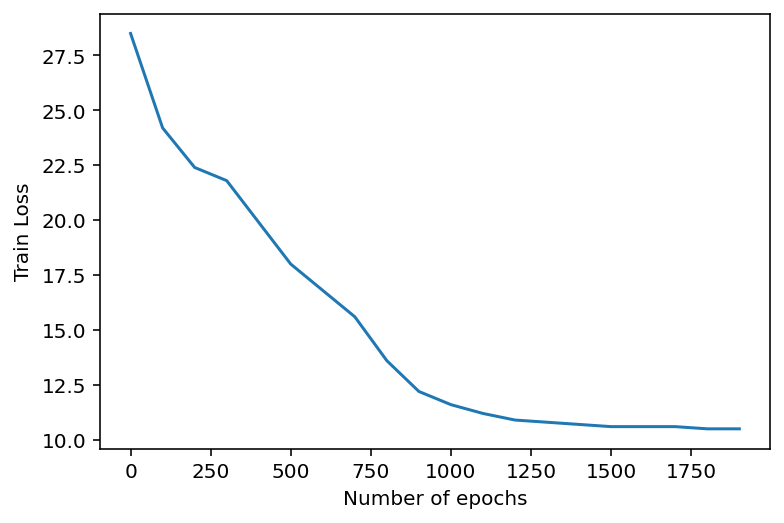

In [78]:
print(e)
print(trl)
fig = plt.figure()
plt.xlabel("Number of epochs")
plt.ylabel("Train Loss")
plt.plot(e, trl)

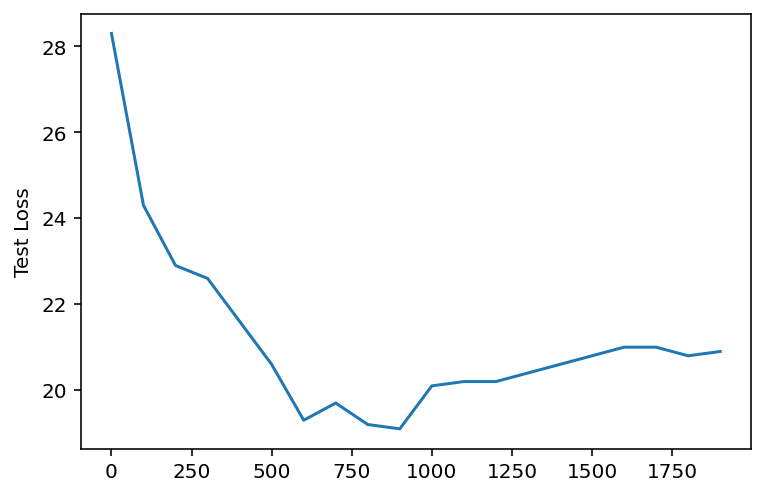

In [79]:
plt.ylabel("Test Loss")
plt.plot(e,tel)

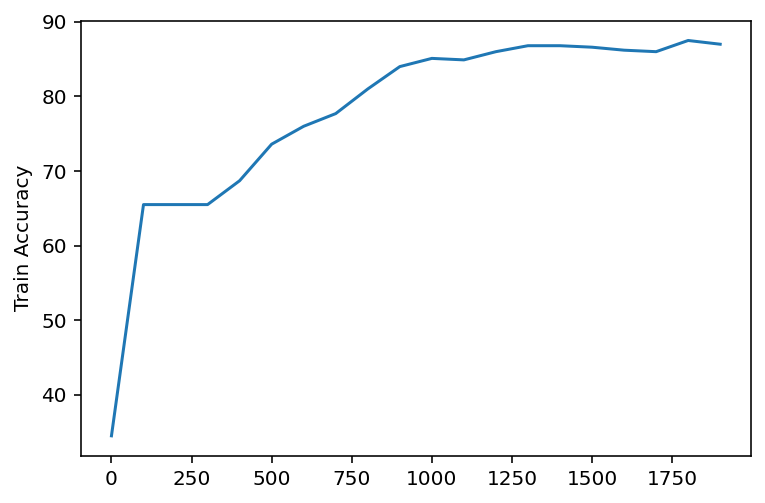

In [80]:
plt.ylabel("Train Accuracy")
plt.plot(e,tra)

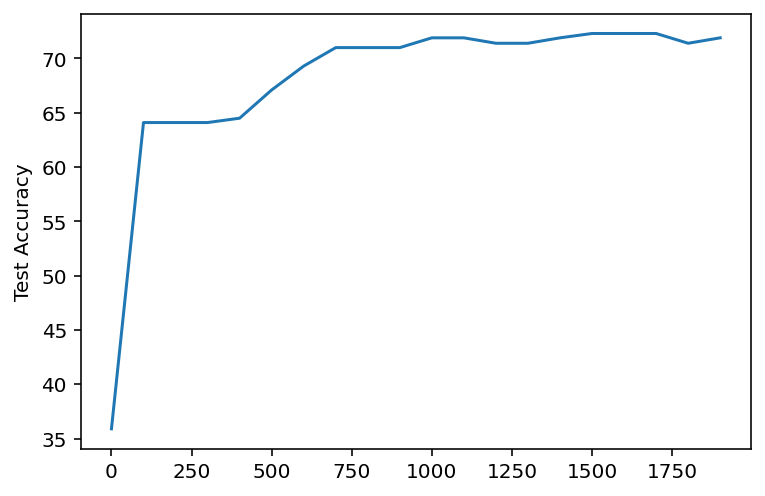

In [81]:
plt.ylabel("Test Accuracy")
plt.plot(e,tea)